In [8]:
# Load data and prepare

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load the batch-corrected dataset
df = pd.read_csv('output/Final_Dataset_ForModeling.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nDiagnosis distribution:")
print(df['Diagnosis'].value_counts())
print(f"\nDataset distribution:")
print(df['Dataset'].value_counts())

# Separate features and target
feature_cols = [c for c in df.columns if c not in ['Diagnosis', 'Dataset']]
X = df[feature_cols]
y = df['Diagnosis']
dataset_labels = df['Dataset']

print(f"\nFeatures: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"\nLabel encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Dataset shape: (1209, 1004)

Diagnosis distribution:
Diagnosis
MCI        519
Control    455
AD         235
Name: count, dtype: int64

Dataset distribution:
Dataset
ADNI        700
GSE63060    329
GSE85426    180
Name: count, dtype: int64

Features: 1002
Samples: 1209

Label encoding: {'AD': 0, 'Control': 1, 'MCI': 2}


In [9]:
# Stratified split by Diagnosis AND Dataset

# Create combined stratification variable
strat_var = df['Diagnosis'] + '_' + df['Dataset']
print("Stratification groups:")
print(strat_var.value_counts())

# Split 80/20
X_train, X_test, y_train, y_test, dataset_train, dataset_test = train_test_split(
    X, y_encoded, dataset_labels,
    test_size=0.2,
    random_state=42,
    stratify=strat_var
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print(f"\nTrain diagnosis distribution:")
print(pd.Series(y_train).map({0: 'AD', 1: 'Control', 2: 'MCI'}).value_counts())

print(f"\nTest diagnosis distribution:")
print(pd.Series(y_test).map({0: 'AD', 1: 'Control', 2: 'MCI'}).value_counts())

print(f"\nTrain dataset distribution:")
print(dataset_train.value_counts())

print(f"\nTest dataset distribution:")
print(dataset_test.value_counts())

Stratification groups:
MCI_ADNI            439
Control_ADNI        261
AD_GSE63060         145
Control_GSE63060    104
Control_GSE85426     90
AD_GSE85426          90
MCI_GSE63060         80
Name: count, dtype: int64

Train set: 967 samples
Test set: 242 samples

Train diagnosis distribution:
MCI        415
Control    364
AD         188
Name: count, dtype: int64

Test diagnosis distribution:
MCI        104
Control     91
AD          47
Name: count, dtype: int64

Train dataset distribution:
Dataset
ADNI        560
GSE63060    263
GSE85426    144
Name: count, dtype: int64

Test dataset distribution:
Dataset
ADNI        140
GSE63060     66
GSE85426     36
Name: count, dtype: int64


In [10]:
# Apply SMOTE to training set only

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {X_train.shape[0]} samples")
print(f"After SMOTE: {X_train_smote.shape[0]} samples")

print(f"\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).map({0: 'AD', 1: 'Control', 2: 'MCI'}).value_counts())

Before SMOTE: 967 samples
After SMOTE: 1245 samples

Class distribution after SMOTE:
MCI        415
Control    415
AD         415
Name: count, dtype: int64


In [11]:
# Train models

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1, eval_metric='mlogloss'),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500, random_state=42, early_stopping=True)
}

# Train and evaluate
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_smote, y_train_smote)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # ROC-AUC (one-vs-rest)
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    except:
        roc_auc = None
    
    results[name] = {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'model': model
    }
    
    print(f"  Accuracy: {acc:.4f}, F1-macro: {f1_macro:.4f}, ROC-AUC: {roc_auc:.4f}")

print("\nTraining complete!")

Training Logistic Regression...
  Accuracy: 0.5785, F1-macro: 0.5895, ROC-AUC: 0.7346
Training Random Forest...
  Accuracy: 0.6281, F1-macro: 0.6044, ROC-AUC: 0.8126
Training XGBoost...
  Accuracy: 0.6736, F1-macro: 0.6691, ROC-AUC: 0.8517
Training SVM...
  Accuracy: 0.6364, F1-macro: 0.5991, ROC-AUC: 0.8170
Training MLP...
  Accuracy: 0.5785, F1-macro: 0.5773, ROC-AUC: 0.7741

Training complete!


MODEL COMPARISON
Model                     Accuracy     F1-Macro     F1-Weighted  ROC-AUC     
Logistic Regression       0.5785       0.5895       0.5776       0.7346      
Random Forest             0.6281       0.6044       0.5948       0.8126      
XGBoost                   0.6736       0.6691       0.6684       0.8517      
SVM                       0.6364       0.5991       0.5839       0.8170      
MLP                       0.5785       0.5773       0.5733       0.7741      

Best model (by F1-macro): XGBoost


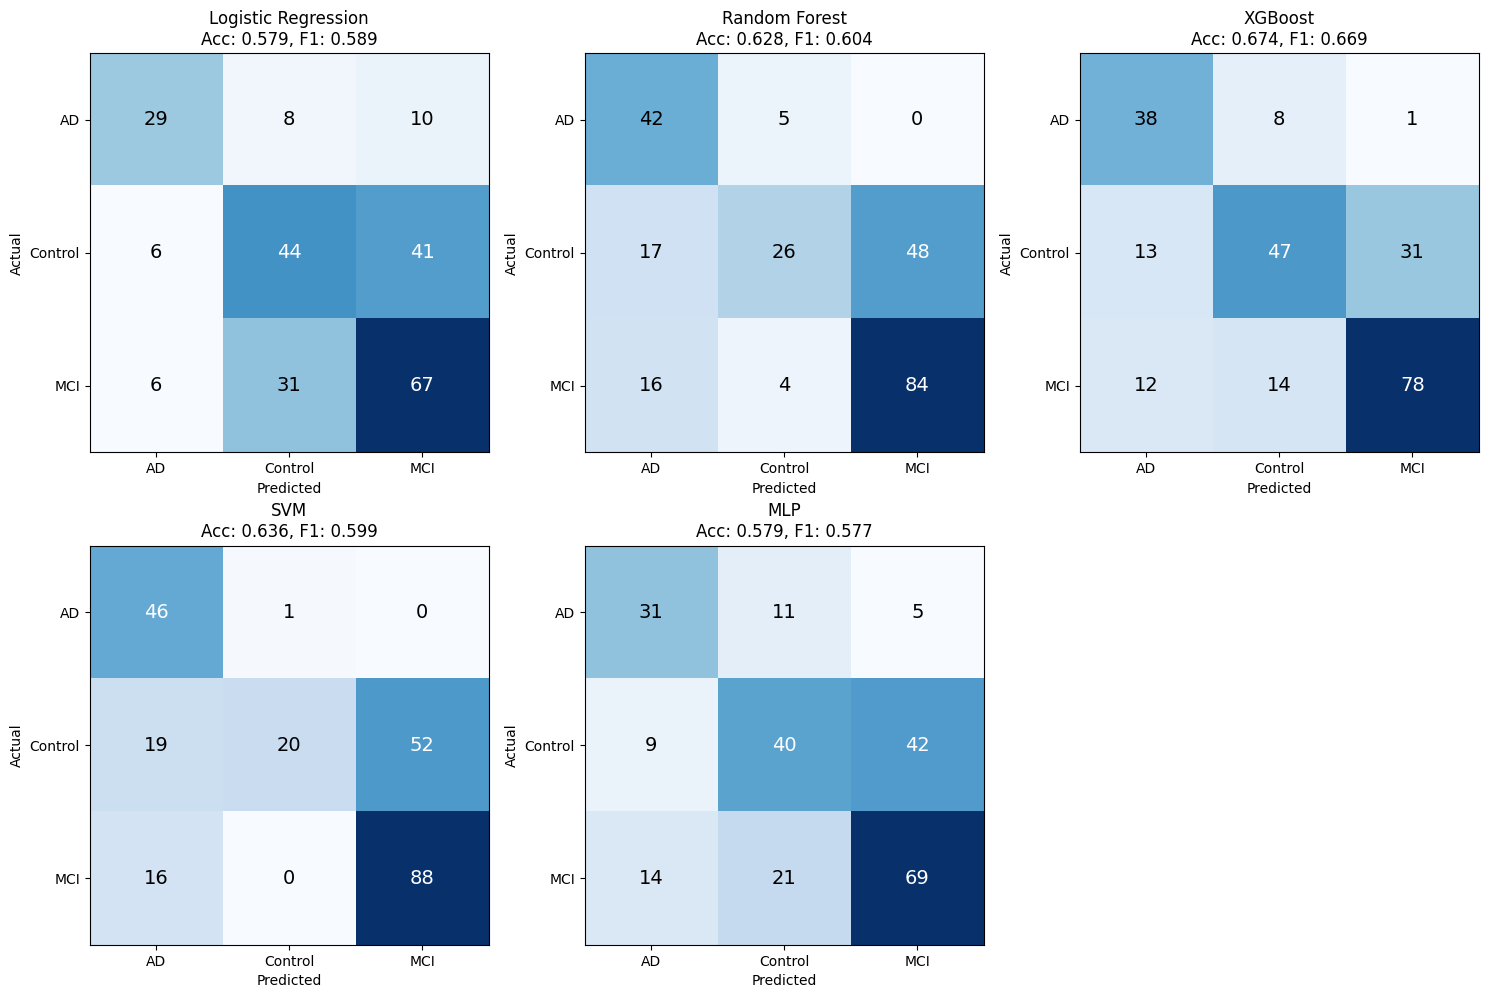


Saved: output/confusion_matrices.png


In [12]:
# Results summary and confusion matrices

import matplotlib.pyplot as plt

# Summary table
print("MODEL COMPARISON")
print(f"{'Model':<25} {'Accuracy':<12} {'F1-Macro':<12} {'F1-Weighted':<12} {'ROC-AUC':<12}")
for name, res in results.items():
    print(f"{name:<25} {res['accuracy']:<12.4f} {res['f1_macro']:<12.4f} {res['f1_weighted']:<12.4f} {res['roc_auc']:<12.4f}")

# Best model
best_model_name = max(results, key=lambda x: results[x]['f1_macro'])
print(f"\nBest model (by F1-macro): {best_model_name}")

# Confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

class_names = ['AD', 'Control', 'MCI']

for idx, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    
    ax = axes[idx]
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f"{name}\nAcc: {res['accuracy']:.3f}, F1: {res['f1_macro']:.3f}")
    
    # Labels
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    # Annotate
    for i in range(3):
        for j in range(3):
            ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=14,
                   color='white' if cm[i, j] > cm.max()/2 else 'black')

# Hide empty subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig('output/confusion_matrices.png', dpi=150)
plt.show()

print("\nSaved: output/confusion_matrices.png")

In [13]:
# 5 x 10 Cross-validation

from sklearn.model_selection import RepeatedStratifiedKFold

# 5 repeats of 10-fold CV
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

cv_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1, eval_metric='mlogloss'),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
}

print("5 x 10-Fold Cross-Validation Results:")

cv_results = {}

for name, model in cv_models.items():
    print(f"Running {name}...", end=" ")
    
    fold_accs = []
    fold_f1s = []
    
    for train_idx, val_idx in rskf.split(X, y_encoded):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y_encoded[train_idx], y_encoded[val_idx]
        
        # Apply SMOTE to training fold
        smote = SMOTE(random_state=42)
        X_tr_smote, y_tr_smote = smote.fit_resample(X_tr, y_tr)
        
        # Train and evaluate
        model_clone = type(model)(**model.get_params())
        model_clone.fit(X_tr_smote, y_tr_smote)
        y_pred = model_clone.predict(X_val)
        
        fold_accs.append(accuracy_score(y_val, y_pred))
        fold_f1s.append(f1_score(y_val, y_pred, average='macro'))
    
    cv_results[name] = {
        'accuracy_mean': np.mean(fold_accs),
        'accuracy_std': np.std(fold_accs),
        'f1_mean': np.mean(fold_f1s),
        'f1_std': np.std(fold_f1s),
        'fold_accs': fold_accs,
        'fold_f1s': fold_f1s
    }
    

print(f"{'Model':<25} {'Accuracy':<20} {'F1-Macro':<20}")
for name, res in cv_results.items():
    print(f"{name:<25} {res['accuracy_mean']:.4f} (+/- {res['accuracy_std']:.4f})   {res['f1_mean']:.4f} (+/- {res['f1_std']:.4f})")

# Best model
best_cv = max(cv_results, key=lambda x: cv_results[x]['f1_mean'])
print(f"\nBest model (by CV F1-macro): {best_cv}")

5 x 10-Fold Cross-Validation Results:
Running Logistic Regression... Running Random Forest... Running XGBoost... Running SVM... Model                     Accuracy             F1-Macro            
Logistic Regression       0.6061 (+/- 0.0420)   0.6080 (+/- 0.0455)
Random Forest             0.6339 (+/- 0.0387)   0.6076 (+/- 0.0451)
XGBoost                   0.6789 (+/- 0.0360)   0.6800 (+/- 0.0371)
SVM                       0.6349 (+/- 0.0297)   0.6018 (+/- 0.0360)

Best model (by CV F1-macro): XGBoost


In [14]:
# Ablation Study: Impact of clinical features

from sklearn.model_selection import RepeatedStratifiedKFold

print("ABLATION STUDY: Impact of Clinical Features")

# Feature sets for ablation
gene_cols = [c for c in df.columns if c not in ['Diagnosis', 'Dataset', 'Age_Zscore', 'Sex_Male']]

ablation_configs = {
    'Genes Only': gene_cols,
    'Genes + Age': gene_cols + ['Age_Zscore'],
    'Genes + Sex': gene_cols + ['Sex_Male'],
    'Genes + Age + Sex': gene_cols + ['Age_Zscore', 'Sex_Male'],
}

# 5x10 CV
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

ablation_results = {}

for config_name, feature_list in ablation_configs.items():
    print(f"\nRunning {config_name} ({len(feature_list)} features)...")
    
    X_ablation = df[feature_list]
    
    fold_accs = []
    fold_f1s = []
    
    for train_idx, val_idx in rskf.split(X_ablation, y_encoded):
        X_tr, X_val = X_ablation.iloc[train_idx], X_ablation.iloc[val_idx]
        y_tr, y_val = y_encoded[train_idx], y_encoded[val_idx]
        
        # SMOTE
        smote = SMOTE(random_state=42)
        X_tr_smote, y_tr_smote = smote.fit_resample(X_tr, y_tr)
        
        # XGBoost
        model = XGBClassifier(
            n_estimators=200, max_depth=5, learning_rate=0.1,
            random_state=42, eval_metric='mlogloss',
            tree_method='hist', device='cuda'
        )
        model.fit(X_tr_smote, y_tr_smote)
        y_pred = model.predict(X_val)
        
        fold_accs.append(accuracy_score(y_val, y_pred))
        fold_f1s.append(f1_score(y_val, y_pred, average='macro'))
    
    ablation_results[config_name] = {
        'accuracy_mean': np.mean(fold_accs),
        'accuracy_std': np.std(fold_accs),
        'f1_mean': np.mean(fold_f1s),
        'f1_std': np.std(fold_f1s),
        'n_features': len(feature_list)
    }
    
    print(f"  Acc: {np.mean(fold_accs):.4f} (+/- {np.std(fold_accs):.4f})")
    print(f"  F1:  {np.mean(fold_f1s):.4f} (+/- {np.std(fold_f1s):.4f})")

# Summary table
print("ABLATION RESULTS SUMMARY")
print(f"{'Configuration':<25} {'Features':<10} {'Accuracy':<22} {'F1-Macro':<22}")
for name, res in ablation_results.items():
    acc_str = f"{res['accuracy_mean']:.4f} (+/- {res['accuracy_std']:.4f})"
    f1_str = f"{res['f1_mean']:.4f} (+/- {res['f1_std']:.4f})"
    print(f"{name:<25} {res['n_features']:<10} {acc_str:<22} {f1_str:<22}")

ABLATION STUDY: Impact of Clinical Features

Running Genes Only (1000 features)...
  Acc: 0.6686 (+/- 0.0479)
  F1:  0.6665 (+/- 0.0512)

Running Genes + Age (1001 features)...
  Acc: 0.6794 (+/- 0.0364)
  F1:  0.6799 (+/- 0.0386)

Running Genes + Sex (1001 features)...
  Acc: 0.6665 (+/- 0.0351)
  F1:  0.6650 (+/- 0.0372)

Running Genes + Age + Sex (1002 features)...
  Acc: 0.6789 (+/- 0.0360)
  F1:  0.6800 (+/- 0.0371)
ABLATION RESULTS SUMMARY
Configuration             Features   Accuracy               F1-Macro              
Genes Only                1000       0.6686 (+/- 0.0479)    0.6665 (+/- 0.0512)   
Genes + Age               1001       0.6794 (+/- 0.0364)    0.6799 (+/- 0.0386)   
Genes + Sex               1001       0.6665 (+/- 0.0351)    0.6650 (+/- 0.0372)   
Genes + Age + Sex         1002       0.6789 (+/- 0.0360)    0.6800 (+/- 0.0371)   


In [15]:
# Gene Count Variation Study

print("GENE COUNT VARIATION STUDY")

# Get feature importance from full XGBoost model
gene_cols = [c for c in df.columns if c not in ['Diagnosis', 'Dataset', 'Age_Zscore', 'Sex_Male']]
print(f"Total genes available: {len(gene_cols)}")

xgb_full = XGBClassifier(
    n_estimators=200, max_depth=5, learning_rate=0.1,
    random_state=42, eval_metric='mlogloss',
    tree_method='hist', device='cuda'
)

# Train on full data to get feature importance ranking
X_full = df[gene_cols]
smote = SMOTE(random_state=42)
X_full_smote, y_full_smote = smote.fit_resample(X_full, y_encoded)
xgb_full.fit(X_full_smote, y_full_smote)

# Get ranked genes
gene_importance = pd.DataFrame({
    'gene': gene_cols,
    'importance': xgb_full.feature_importances_
}).sort_values('importance', ascending=False)

ranked_genes = gene_importance['gene'].tolist()

# Gene counts to test
gene_counts = [250, 500, 1000]

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

gene_count_results = {}

for n_genes in gene_counts:
    print(f"\nRunning with {n_genes} genes + Age + Sex...")
    
    top_n_genes = ranked_genes[:n_genes]
    feature_list = top_n_genes + ['Age_Zscore', 'Sex_Male']
    X_subset = df[feature_list]
    
    fold_accs = []
    fold_f1s = []
    
    for train_idx, val_idx in rskf.split(X_subset, y_encoded):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_encoded[train_idx], y_encoded[val_idx]
        
        smote = SMOTE(random_state=42)
        X_tr_smote, y_tr_smote = smote.fit_resample(X_tr, y_tr)
        
        model = XGBClassifier(
            n_estimators=200, max_depth=5, learning_rate=0.1,
            random_state=42, eval_metric='mlogloss',
            tree_method='hist', device='cuda'
        )
        model.fit(X_tr_smote, y_tr_smote)
        y_pred = model.predict(X_val)
        
        fold_accs.append(accuracy_score(y_val, y_pred))
        fold_f1s.append(f1_score(y_val, y_pred, average='macro'))
    
    gene_count_results[n_genes] = {
        'accuracy_mean': np.mean(fold_accs),
        'accuracy_std': np.std(fold_accs),
        'f1_mean': np.mean(fold_f1s),
        'f1_std': np.std(fold_f1s)
    }
    
    print(f"  Acc: {np.mean(fold_accs):.4f} (+/- {np.std(fold_accs):.4f})")
    print(f"  F1:  {np.mean(fold_f1s):.4f} (+/- {np.std(fold_f1s):.4f})")

# Summary
print("GENE COUNT RESULTS SUMMARY")
print(f"{'N Genes':<10} {'Accuracy':<22} {'F1-Macro':<22}")
for n_genes, res in gene_count_results.items():
    acc_str = f"{res['accuracy_mean']:.4f} (+/- {res['accuracy_std']:.4f})"
    f1_str = f"{res['f1_mean']:.4f} (+/- {res['f1_std']:.4f})"
    print(f"{n_genes:<10} {acc_str:<22} {f1_str:<22}")

best_n = max(gene_count_results, key=lambda x: gene_count_results[x]['f1_mean'])
print(f"\nOptimal gene count: {best_n}")

GENE COUNT VARIATION STUDY
Total genes available: 1000

Running with 250 genes + Age + Sex...
  Acc: 0.6907 (+/- 0.0441)
  F1:  0.6944 (+/- 0.0442)

Running with 500 genes + Age + Sex...
  Acc: 0.6976 (+/- 0.0353)
  F1:  0.6996 (+/- 0.0373)

Running with 1000 genes + Age + Sex...
  Acc: 0.6763 (+/- 0.0389)
  F1:  0.6780 (+/- 0.0404)
GENE COUNT RESULTS SUMMARY
N Genes    Accuracy               F1-Macro              
250        0.6907 (+/- 0.0441)    0.6944 (+/- 0.0442)   
500        0.6976 (+/- 0.0353)    0.6996 (+/- 0.0373)   
1000       0.6763 (+/- 0.0389)    0.6780 (+/- 0.0404)   

Optimal gene count: 500


In [16]:
# Hyperparameter Tuning for XGBoost (with optimal 500 genes + Age + Sex)

from sklearn.model_selection import GridSearchCV
import time

print("HYPERPARAMETER TUNING - XGBoost")

# Use optimal 500 genes + clinical features
optimal_genes = ranked_genes[:500]
feature_list = optimal_genes + ['Age_Zscore', 'Sex_Male']
X_opt = df[feature_list]

print(f"Features: {len(feature_list)} (500 genes + Age + Sex)")

# Prepare data with SMOTE
smote = SMOTE(random_state=42)
X_opt_smote, y_opt_smote = smote.fit_resample(X_opt, y_encoded)

print(f"Training samples after SMOTE: {len(X_opt_smote)}")

# Reduced grid search 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
}

total_combinations = 2 * 3 * 2 * 2
print(f"Total combinations: {total_combinations}")
print(f"With 5-fold CV: {total_combinations * 5} fits")

# Base model
xgb_base = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    tree_method='hist',
    device='cpu'
)

# Grid search with 5-fold CV
print("\nRunning grid search...")
start_time = time.time()

grid_search = GridSearchCV(
    xgb_base,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_opt_smote, y_opt_smote)

elapsed = time.time() - start_time
print(f"\nCompleted in {elapsed:.1f}s ({elapsed/60:.1f} min)")

# Results
print("TUNING RESULTS")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV F1-macro: {grid_search.best_score_:.4f}")

# Compare default vs tuned
print("Default vs Tuned comparison:")
print(f"  Default (from gene count study): F1 = 0.6919")
print(f"  Tuned:                           F1 = {grid_search.best_score_:.4f}")
print(f"  Improvement: {(grid_search.best_score_ - 0.6919)*100:.2f}%")

HYPERPARAMETER TUNING - XGBoost
Features: 502 (500 genes + Age + Sex)
Training samples after SMOTE: 1557
Total combinations: 24
With 5-fold CV: 120 fits

Running grid search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Completed in 135.0s (2.3 min)
TUNING RESULTS
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best CV F1-macro: 0.7012
Default vs Tuned comparison:
  Default (from gene count study): F1 = 0.6919
  Tuned:                           F1 = 0.7012
  Improvement: 0.93%


In [20]:
# Bayesian Optimization for XGBoost

from skopt import BayesSearchCV
from skopt.space import Integer, Real
import time


print("BAYESIAN OPTIMIZATION - XGBoost")

# Use optimal 500 genes + clinical features
print(f"Features: {len(feature_list)} (500 genes + Age + Sex)")
print(f"Training samples after SMOTE: {len(X_opt_smote)}")

# Define search space
search_space = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'min_child_weight': Integer(1, 5),
}

# Base model
xgb_base = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    tree_method='hist',
    device='cpu'
)

# Bayesian search (30 iterations)
print("\nRunning Bayesian optimization (30 iterations)...")
start_time = time.time()

bayes_search = BayesSearchCV(
    xgb_base,
    search_space,
    n_iter=30,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

bayes_search.fit(X_opt_smote, y_opt_smote)

elapsed = time.time() - start_time
print(f"\nCompleted in {elapsed:.1f}s ({elapsed/60:.1f} min)")

# Results
print("BAYESIAN OPTIMIZATION RESULTS")
print(f"Best parameters: {bayes_search.best_params_}")
print(f"Best CV F1-macro: {bayes_search.best_score_:.4f}")

# Compare all methods
print("COMPARISON:")
print(f"  Default:              F1 = 0.6919")
print(f"  Grid Search:          F1 = 0.7046")
print(f"  Bayesian Optimization: F1 = {bayes_search.best_score_:.4f}")

# Best overall
best_f1 = max(0.7046, bayes_search.best_score_)
best_method = "Grid Search" if 0.7046 >= bayes_search.best_score_ else "Bayesian Optimization"
print(f"\nBest method: {best_method} (F1 = {best_f1:.4f})")

BAYESIAN OPTIMIZATION - XGBoost
Features: 502 (500 genes + Age + Sex)
Training samples after SMOTE: 1557

Running Bayesian optimization (30 iterations)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for

TEST SET EVALUATION
Best params: {'colsample_bytree': 0.7275965127333363, 'learning_rate': 0.1331847174720591, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}
Accuracy:       0.6860
Macro F1:       0.6854
Weighted F1:    0.6811
Cohen's Kappa:  0.5115
MCC:            0.5149
ROC-AUC (OvR):  0.8609

Classification report:
              precision    recall  f1-score   support

          AD       0.66      0.81      0.72        47
     Control       0.67      0.54      0.60        91
         MCI       0.71      0.76      0.73       104

    accuracy                           0.69       242
   macro avg       0.68      0.70      0.69       242
weighted avg       0.69      0.69      0.68       242



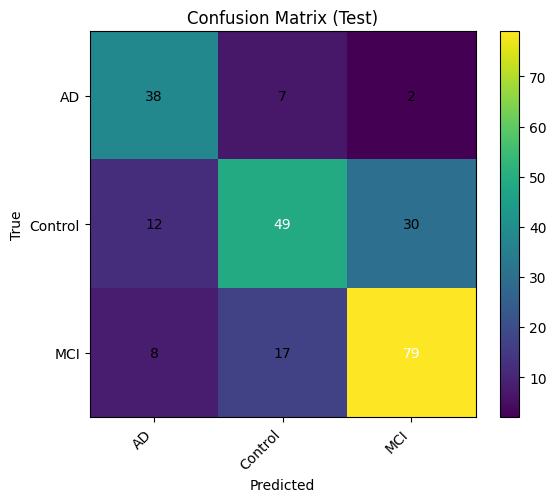

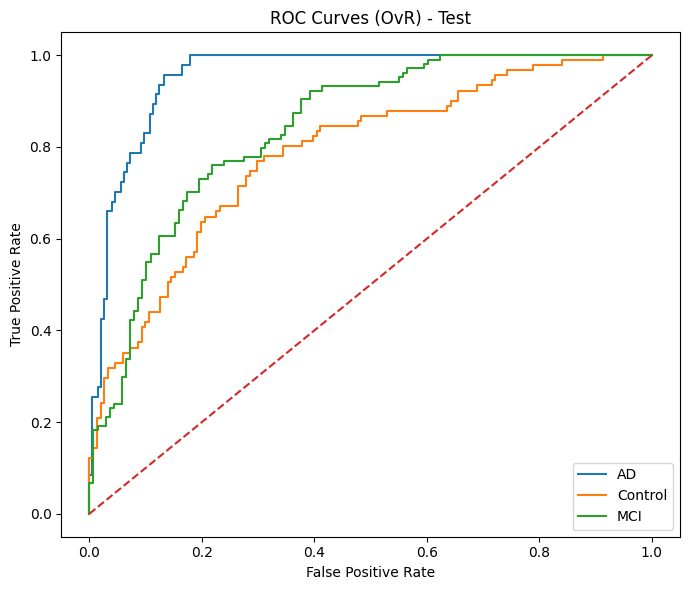

In [21]:
# EVALUATE BAYESIAN BEST XGBOOST

import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    cohen_kappa_score, matthews_corrcoef, roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize

_search_obj = None
for name in ["bayes_search", "bayes_opt", "opt", "bayes", "bayes_cv"]:
    if name in globals():
        _search_obj = globals()[name]
        break

if _search_obj is None or not hasattr(_search_obj, "best_params_"):
    raise NameError(
        "Couldn't find a fitted BayesSearchCV object. "
        "Make sure you've run the Bayesian optimization cell first "
        "(e.g., bayes_search.fit(...))."
    )

best_params = dict(_search_obj.best_params_)  
if "le" in globals():
    y_test_enc = le.transform(y_test) if y_test.dtype.kind in {"U","S","O"} else np.asarray(y_test).astype(int)
    class_names = list(le.classes_)
else:
    y_test_enc = np.asarray(y_test).astype(int)
    class_names = [f"class_{i}" for i in np.unique(y_test_enc)]

n_classes = len(np.unique(y_test_enc))


if any(k.startswith("xgb__") for k in best_params.keys()):
    best_params = {k.replace("xgb__", ""): v for k, v in best_params.items()}

xgb_best = XGBClassifier(
    **best_params,
    objective="multi:softprob",
    num_class=n_classes,
    random_state=42,
    n_jobs=-1,
    eval_metric="mlogloss"
)

xgb_best.fit(X_train_smote, y_train_smote)

y_pred = xgb_best.predict(X_test)
y_proba = xgb_best.predict_proba(X_test)

acc = accuracy_score(y_test_enc, y_pred)
f1_macro = f1_score(y_test_enc, y_pred, average="macro")
f1_weighted = f1_score(y_test_enc, y_pred, average="weighted")
kappa = cohen_kappa_score(y_test_enc, y_pred)
mcc = matthews_corrcoef(y_test_enc, y_pred)

y_test_bin = label_binarize(y_test_enc, classes=list(range(n_classes)))
roc_auc_ovr = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")

print("TEST SET EVALUATION")
print("Best params:", best_params)
print(f"Accuracy:       {acc:.4f}")
print(f"Macro F1:       {f1_macro:.4f}")
print(f"Weighted F1:    {f1_weighted:.4f}")
print(f"Cohen's Kappa:  {kappa:.4f}")
print(f"MCC:            {mcc:.4f}")
print(f"ROC-AUC (OvR):  {roc_auc_ovr:.4f}\n")
print("Classification report:")
print(classification_report(y_test_enc, y_pred, target_names=class_names))

# Confusion matrix plot
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.colorbar()
ticks = np.arange(n_classes)
plt.xticks(ticks, class_names, rotation=45, ha="right")
plt.yticks(ticks, class_names)
plt.xlabel("Predicted")
plt.ylabel("True")

thresh = cm.max() / 2.0 if cm.max() > 0 else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# 7) ROC curves (OvR)
plt.figure(figsize=(7, 6))
for c in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, c], y_proba[:, c])
    plt.plot(fpr, tpr, label=f"{class_names[c]}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (OvR) - Test")
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
import shap

print(f"\nSHAP values shape: {np.array(shap_values).shape}")
if np.array(shap_values).ndim == 3:
    shap_values_by_class = np.transpose(shap_values, (2, 0, 1))
else:
    shap_values_by_class = shap_values

class_names_map = {0: 'AD', 1: 'Control', 2: 'MCI'}
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']



SHAP values shape: (242, 1002, 3)
